In [1]:
import os
import sys
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
pd.options.display.max_columns = None
pd.options.display.max_rows = None
from modules import *
from execution import *
import json
import pprint

In [2]:
def print_df(df_mlp, df_sa, verbose=True):
    cols = df_mlp.columns.tolist()
    layer_track_cols = ['activation_buffer', 'weights_mem', 
                        'weights_grad_mem', 'flops_fwd', 'flops_bwd', 
                        't_fwd', 't_fwd_comm', 't_bwd', 't_bwd_comm']
    if verbose:
        display(df_mlp[cols])
        display(df_mlp[layer_track_cols].sum() * depth)
        display(df_sa[cols])
        display(df_sa[layer_track_cols].sum() * depth)
    t_itr = (df_mlp['t_fwd'].sum() + df_mlp['t_bwd'].sum() + df_sa['t_fwd'].sum() + df_sa['t_bwd'].sum()) * depth
    print('time for 1 itr = {}'.format(t_itr))

    f1 = 3 # 1 fp16 wt, 1 fp32 copy
    f2 = 5 # 1 fp16 grad, 2 fp32 means and variances
    mem = (df_mlp['weights_mem'].sum() * f1 + df_mlp['weights_grad_mem'].sum() * f2 + df_mlp['activation_buffer'].sum() +
           df_sa['weights_mem'].sum() * f1 + df_sa['weights_grad_mem'].sum() * f2 + df_sa['activation_buffer'].sum()) * depth
    
    param_count = ((df_mlp['weights_mem'].sum() + df_sa['weights_mem'].sum()) * depth) / system['element_size']
    print('mem consumed = {}'.format(mem))
    print('num parameters = {}B'.format(param_count/1E9))

In [3]:
### model
gpt2 = {'l': 1024, 'e': 1600, 'h': 32, 'depth': 48}
gpt3_xl = {'l': 2048, 'e': 2048, 'h': 16, 'depth': 24}
gpt3 = {'l': 2048, 'e': 12288, 'h': 96, 'depth': 96}
gpt3_1T = {'l': 2048, 'e': 25600, 'h': 160, 'depth': 128}
gpt3_1T_fut = {'l': 2048, 'e': 25600, 'h': 160, 'depth': 128*3}
gpt3_1T_alt = {'l': 2048, 'e': 32768, 'h': 128, 'depth': 128}
gpt3_1T_alt_fut = {'l': 2048, 'e': 32768, 'h': 128, 'depth': 128*3}
gpt3_lowdepth = {'l': 2048, 'e': 12288, 'h': 96, 'depth': 96 // 8}
vit_era5 = {'l': 64800*4, 'e': 4096, 'h': 32, 'depth': 32}
vit_era5_v2 = {'l': 64800, 'e': 4096, 'h': 32, 'depth': 32}
vit_era5_big = {'l': 64800, 'e': 12288, 'h': 128, 'depth': 64}
model = gpt3_1T
b = 1
l = model['l']
e = model['e']
f = 4 * e
h = model['h']
depth = model['depth']
print("model: batch size = {}, seq length = {}, embed = {}, attention heads = {}, depth = {}".format(b, l, e, h, depth))

with open('systems/config-B200.json', 'r') as file:
    system = json.load(file)

model: batch size = 1, seq length = 2048, embed = 25600, attention heads = 160, depth = 128


In [4]:
m1 = 1
system['nvlink_size'] = 4
t1 = m1 if m1 <= system['nvlink_size'] else system['nvlink_size']
df_mlp = mlp_1d(b, l, e, f, parallelism={'m': m1}, topology={'t': t1}, system=system)
df_sa = sa_1d(b, l, e, h, parallelism={'m': m1}, topology={'t': t1}, flash_attention=True, system=system)
print_df(df_mlp, df_sa, verbose=True)

,name,weights_mem,weights_grad_mem,flops_fwd,activation_buffer,comm_fwd,comm_fwd_type,flops_bwd,comm_bwd,comm_bwd_type,t_fwd,t_fwd_comm,t_fwd_comp,t_fwd_mem,intensity_fwd,t_bwd,t_bwd_comm,t_bwd_comp,t_bwd_mem,intensity_bwd,t
0,fc1,5.242880,5.242880,10.737209,0.104858,0,reducescatter,21.472163,0,reducescatter,0.004295,0,4.294883e-03,0.000721,5.957702,0.008589,0,8.588865e-03,0.001442,5.957076,0.012884
1,fc1-bias,0.000205,0.000205,0.000210,0.000000,0,none,0.000210,0,none,0.000052,0,6.186289e-07,0.000052,0.011794,0.000052,0,6.186289e-07,0.000052,0.011794,0.000105
2,act1,0.000000,0.000000,0.000210,0.419430,0,none,0.000210,0,none,0.000105,0,6.186289e-07,0.000105,0.005900,0.000157,0,6.186289e-07,0.000157,0.003933,0.000262
3,dpr1,0.000000,0.000000,0.000210,0.209715,0,none,0.000210,0,none,0.000131,0,6.186289e-07,0.000131,0.004720,0.000131,0,6.186289e-07,0.000131,0.004720,0.000262
4,fc2,5.242880,5.242880,10.737366,0.419430,0,reducescatter,21.472005,0,reducescatter,0.004295,0,4.294946e-03,0.000721,5.957789,0.008589,0,8.588802e-03,0.001442,5.957033,0.012884
5,fc2-bias,0.000051,0.000051,0.000052,0.000000,0,none,0.000052,0,none,0.000013,0,1.546572e-07,0.000013,0.011794,0.000013,0,1.546572e-07,0.000013,0.011794,0.000026
6,dpr2,0.000000,0.000000,0.000052,0.052429,0,none,0.000052,0,none,0.000033,0,1.546572e-07,0.000033,0.004720,0.000033,0,1.546572e-07,0.000033,0.004720,0.000066
7,ln1,0.000102,0.000102,0.000472,0.104858,0,allgather,0.000629,0,reducescatter,0.000026,0,1.391915e-06,0.000026,0.053069,0.000066,0,1.855863e-06,0.000066,0.028313,0.000092


activation_buffer     167.772160
weights_mem          1342.223155
weights_grad_mem     1342.223155
flops_fwd            2748.899865
flops_bwd            5497.027978
t_fwd                   1.145641
t_fwd_comm              0.000000
t_bwd                   2.256629
t_bwd_comm              0.000000
dtype: float64

,name,weights_mem,weights_grad_mem,flops_fwd,activation_buffer,comm_fwd,comm_fwd_type,flops_bwd,comm_bwd,comm_bwd_type,t_fwd,t_fwd_comm,t_fwd_comp,t_fwd_mem,intensity_fwd,t_bwd,t_bwd_comm,t_bwd_comp,t_bwd_mem,intensity_bwd,t
0,qkv,3.932160,3.932160,8.052906,0.104858,0,reducescatter,16.104109,0,reducescatter,0.003221,0,3.221163e-03,0.000544,5.921812,0.006442,0,6.441644e-03,0.001088,5.921186,0.009663
1,fusedla,0.000000,0.000000,0.448567,0.420741,0,none,1.116779,0,none,0.000179,0,1.794268e-04,0.000053,3.416955,0.000447,0,4.467115e-04,0.000105,4.253527,0.000626
2,vproj,1.310720,1.310720,2.684302,0.104858,0,reducescatter,5.368001,0,reducescatter,0.001074,0,1.073721e-03,0.000190,5.649545,0.002147,0,2.147201e-03,0.000380,5.648910,0.003221
3,vproj-bias,0.000051,0.000051,0.000052,0.000000,0,none,0.000052,0,none,0.000013,0,1.546572e-07,0.000013,0.011794,0.000013,0,1.546572e-07,0.000013,0.011794,0.000026
4,dpr_v,0.000000,0.000000,0.000052,0.052429,0,none,0.000052,0,none,0.000033,0,1.546572e-07,0.000033,0.004720,0.000033,0,1.546572e-07,0.000033,0.004720,0.000066
5,ln2,0.000102,0.000102,0.000472,0.104858,0,allgather,0.000629,0,reducescatter,0.000026,0,1.391915e-06,0.000026,0.053069,0.000066,0,1.855863e-06,0.000066,0.028313,0.000092


activation_buffer     100.831068
weights_mem           671.108301
weights_grad_mem      671.108301
flops_fwd            1431.853077
flops_bwd            2891.471742
t_fwd                   0.581942
t_fwd_comm              0.000000
t_bwd                   1.170814
t_bwd_comm              0.000000
dtype: float64

time for 1 itr = 5.155025911224943
mem consumed = 16375.254876160001
num parameters = 1006.665728B


In [5]:
# give the entire config and test the result
global_batch_size = 4096
tp = 4
pp = 8
dp = 64
mbs = 1
nm = (global_batch_size / dp) / mbs
print("total gpus = {}, bubble frac = {}".format(tp * pp * dp, (pp - 1) / nm))

with open('systems/config-B200.json', 'r') as file:
    system = json.load(file)
system['nvlink_size'] = 4

m1 = tp
t1 = m1 if m1 <= system['nvlink_size'] else system['nvlink_size']
df_mlp = mlp_1d(mbs, l, e, f, parallelism={'m': m1}, topology={'t': t1}, system=system)
df_sa = sa_1d(mbs, l, e, h, parallelism={'m': m1}, topology={'t': t1}, flash_attention=True, system=system)

(t,mem), stats = totals(df_mlp, df_sa, depth, pp=pp, dp=dp, number_micro_batches=nm)
print(t, mem)
pprint.pprint(stats)

total gpus = 2048, bubble frac = 0.109375
11.647819031901294 157.08566784
{'acts': 87.28346624000001,
 'bubble_frac': 0.09859154929577464,
 'comm_frac': 0.012803324680821902,
 'eff': 0.8635389437322595,
 't_bubble': 1.1483765242719586,
 't_comm': 0.1491308088888889,
 't_comp': 10.058345343592553,
 't_mem': 2.1275061780480002,
 'wts': 62.9202944,
 'wts_grad': 0.9831296,
 'wts_optimizer_states': 5.898777600000001}


In [6]:
m1 = 2
m2 = 2
t1 = 4
t2 = 1
system['nvlink_size'] = 4
system['summa_nb'] = 16
df_mlp = mlp_2d(b, l, e, f, parallelism={'m1': m1, 'm2': m2}, topology={'t1': t1, 't2': t2}, system=system)
df_sa = sa_2d_seqp(b, l, e, h, parallelism={'m1': m1, 'm2': m2}, topology={'t1': t1, 't2': t2}, flash_attention=True, system=system)
print_df(df_mlp, df_sa)

,name,weights_mem,weights_grad_mem,flops_fwd,activation_buffer,comm_fwd,comm_fwd_type,flops_bwd,comm_bwd,comm_bwd_type,t_fwd,t_fwd_comm,t_fwd_comp,t_fwd_mem,intensity_fwd,t_bwd,t_bwd_comm,t_bwd_comp,t_bwd_mem,intensity_bwd,t
0,fc1,1.310720,1.310720,2.684355,0.026214,"[0.052428800000000005, 2.62144]","[broadcast, broadcast]",5.367372,"[2.62144, 0.052428800000000005, 0.052428800000...","[broadcast, reduce, broadcast, reduce]",3.516416e-02,3.409042e-02,1.073742e-03,5.439488e-04,1.973976,0.070328,6.818137e-02,2.146949e-03,0.001088,1.973484,0.105492
1,fc1-bias,0.000102,0.000102,0.000052,0.000000,0,none,0.000052,0,none,1.312000e-05,0.000000e+00,1.546572e-07,1.312000e-05,0.011788,0.000013,0.000000e+00,1.546572e-07,0.000013,0.011788,0.000026
2,act1,0.000000,0.000000,0.000052,0.104858,0,none,0.000052,0,none,2.621440e-05,0.000000e+00,1.546572e-07,2.621440e-05,0.005900,0.000039,0.000000e+00,1.546572e-07,0.000039,0.003933,0.000066
3,dpr1,0.000000,0.000000,0.000052,0.052429,0,none,0.000052,0,none,3.276800e-05,0.000000e+00,1.546572e-07,3.276800e-05,0.004720,0.000033,0.000000e+00,1.546572e-07,0.000033,0.004720,0.000066
4,fc2,1.310720,1.310720,2.684355,0.104858,"[0.20971520000000002, 2.62144]","[broadcast, broadcast]",5.367294,"[2.62144, 0.20971520000000002, 0.2097152000000...","[broadcast, reduce, broadcast, reduce]",3.620864e-02,3.513490e-02,1.073742e-03,4.063232e-04,2.642581,0.072417,7.027036e-02,2.146917e-03,0.000813,2.641884,0.108626
5,fc2-bias,0.000026,0.000026,0.000013,0.000000,0,none,0.000013,0,none,3.280000e-06,0.000000e+00,3.866431e-08,3.280000e-06,0.011788,0.000003,0.000000e+00,3.866431e-08,0.000003,0.011788,0.000007
6,dpr2,0.000000,0.000000,0.000013,0.013107,0,none,0.000013,0,none,8.192000e-06,0.000000e+00,3.866431e-08,8.192000e-06,0.004720,0.000008,0.000000e+00,3.866431e-08,0.000008,0.004720,0.000016
7,ln1,0.000004,0.000004,0.000009,0.002097,0.000004,allreduce,0.000013,0.000055,allreduce,5.509120e-07,2.560000e-08,2.783830e-08,5.253120e-07,0.052994,0.000002,3.456000e-07,3.710565e-08,0.000001,0.028298,0.000002


activation_buffer      38.856032
weights_mem           335.561228
weights_grad_mem      335.561228
flops_fwd             687.219463
flops_bwd            1374.062311
t_fwd                   9.146486
t_fwd_comm              8.860844
t_bwd                  18.284024
t_bwd_comm             17.721866
dtype: float64

,name,weights_mem,weights_grad_mem,flops_fwd,activation_buffer,comm_fwd,comm_fwd_type,flops_bwd,comm_bwd,comm_bwd_type,t_fwd,t_fwd_comm,t_fwd_comp,t_fwd_mem,intensity_fwd,t_bwd,t_bwd_comm,t_bwd_comp,t_bwd_mem,intensity_bwd,t
0,qkv,0.983040,0.983040,2.013266,0.026214,"[0.052428800000000005, 1.96608]","[broadcast, broadcast]",4.025523,"[1.96608, 0.052428800000000005, 0.052428800000...","[broadcast, reduce, broadcast, reduce]",2.646016e-02,2.565485e-02,8.053064e-04,4.096000e-04,1.966080,0.052920,5.131011e-02,1.610209e-03,0.000819,1.965587,0.079380
1,fusedla,0.000000,0.000000,0.112142,0.105185,0.104858,allgather,0.279168,"[0.10485760000000001, 0.10485760000000001]","[allgather, reducescatter]",7.002167e-04,6.553600e-04,4.485669e-05,1.968128e-05,2.279155,0.001422,1.310720e-03,1.116674e-04,0.000033,3.403564,0.002123
2,vproj,0.327680,0.327680,0.671089,0.026214,"[0.052428800000000005, 0.65536]","[broadcast, broadcast]",1.341823,"[0.65536, 0.052428800000000005, 0.052428800000...","[broadcast, reduce, broadcast, reduce]",9.052160e-03,8.783725e-03,2.684355e-04,1.409024e-04,1.905116,0.018104,1.756759e-02,5.367294e-04,0.000282,1.904614,0.027156
3,vproj-bias,0.000026,0.000026,0.000013,0.000000,0,none,0.000013,0,none,3.280000e-06,0.000000e+00,3.866431e-08,3.280000e-06,0.011788,0.000003,0.000000e+00,3.866431e-08,0.000003,0.011788,0.000007
4,dpr_v,0.000000,0.000000,0.000013,0.013107,0,none,0.000013,0,none,8.192000e-06,0.000000e+00,3.866431e-08,8.192000e-06,0.004720,0.000008,0.000000e+00,3.866431e-08,0.000008,0.004720,0.000016
5,ln2,0.000004,0.000004,0.000009,0.002097,0.000004,allreduce,0.000013,0.000055,allreduce,5.509120e-07,2.560000e-08,2.783830e-08,5.253120e-07,0.052994,0.000002,3.456000e-07,3.710565e-08,0.000001,0.028298,0.000002


activation_buffer     22.120759
weights_mem          167.775961
weights_grad_mem     167.775961
flops_fwd            357.956089
flops_bwd            722.758816
t_fwd                  4.636744
t_fwd_comm             4.492027
t_bwd                  9.274900
t_bwd_comm             8.984162
dtype: float64

time for 1 itr = 41.3421541856232
mem consumed = 4087.6743065600012
num parameters = 251.66859468800004B


In [7]:
def plot(n_gpus, system, axs, lgnd=['MLP', 'SA'], lgnd_tot=['nvlink1'], lfmt="-"):
    t_mlp = []
    t_sa = []
    t_itr = []

    for n in n_gpus:
        m1 = n
        t1 = m1 if m1 <= system['nvlink_size'] else system['nvlink_size']
        
        df_mlp = mlp_1d(b, l, e, f, parallelism={'m': m1}, topology={'t': t1}, system=system)
        df_sa = sa_1d(b, l, e, h, parallelism={'m': m1}, topology={'t': t1}, flash_attention=True, system=system)

        t_mlp_ = (df_mlp['t_fwd'].sum() + df_mlp['t_bwd'].sum()) * depth
        t_sa_ = (df_sa['t_fwd'].sum() + df_sa['t_bwd'].sum()) * depth
        t_itr.append(t_mlp_ + t_sa_)
        t_mlp.append(t_mlp_)
        t_sa.append(t_sa_)

    
    ax = axs[0]
    ax.plot(n_gpus, t_mlp, lfmt, linewidth=2, c=c1)
    ax.plot(n_gpus, t_sa, lfmt, linewidth=2, c=c2)
    ax.set_yscale('log')
    ax.set_xscale('log', base=2)
    ax.set_xlabel('Number of GPUs', fontsize=fsz)
    ax.set_xticks(n_gpus)
    ax.set_xticklabels(n_gpus, fontsize=fsz-4)
    ax.set_ylabel('Time', fontsize=fsz)    
    ax.legend(lgnd, fontsize=fsz-4)
    
    ax = axs[1]
    ax.plot(n_gpus, t_itr, lfmt, linewidth=2)
    ax.set_yscale('log')
    ax.set_xscale('log', base=2)
    ax.set_xlabel('Number of GPUs', fontsize=fsz)
    ax.set_xticks(n_gpus)
    ax.set_xticklabels(n_gpus, fontsize=fsz-4)
    ax.set_ylabel('Total time', fontsize=fsz)
    ax.legend(lgnd_tot, fontsize=fsz-4)
    ax.yaxis.set_minor_formatter(FormatStrFormatter("%d"))

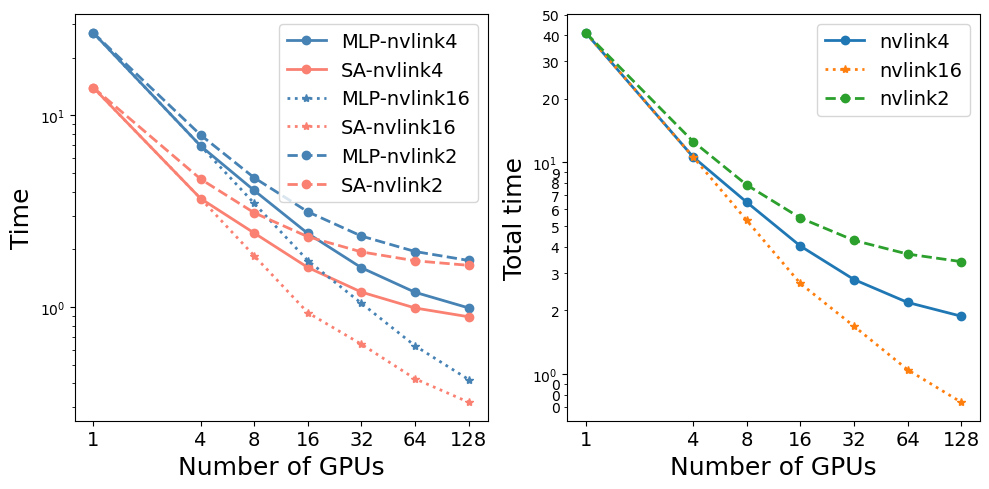

In [8]:
# Sweeps
### model parallelism
n_gpus = [1, 4, 8, 16, 32, 64, 128]
with open('systems/config-A100.json', 'r') as file:
    system = json.load(file)
fig, axs = plt.subplots(1,2,figsize=(10,5), tight_layout=True) 
c1 = 'steelblue'
c2 = 'salmon'
fsz = 18

nvs = 4
system['nvlink_size'] = nvs
lgnd = ["MLP-nvlink{}".format(nvs), "SA-nvlink{}".format(nvs)]
lgnd_tot = ["nvlink{}".format(nvs)]
plot(n_gpus, system, axs, lgnd=lgnd, lgnd_tot=lgnd_tot, lfmt="o-")
nvs = 16
system['nvlink_size'] = nvs
lgnd += ["MLP-nvlink{}".format(nvs), "SA-nvlink{}".format(nvs)]
lgnd_tot += ["nvlink{}".format(nvs)]
plot(n_gpus, system, axs, lgnd=lgnd, lgnd_tot=lgnd_tot, lfmt="*:")
nvs = 2
system['nvlink_size'] = nvs
lgnd += ["MLP-nvlink{}".format(nvs), "SA-nvlink{}".format(nvs)]
lgnd_tot += ["nvlink{}".format(nvs)]
plot(n_gpus, system, axs, lgnd=lgnd, lgnd_tot=lgnd_tot, lfmt="o--")

In [9]:
def set_gpus(n, nvs):
    parallelism = {}
    topology = {}
    factors_of_n = [[i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0]
    best_factor = factors_of_n[-1]
    parallelism['m1'] = best_factor[0]
    parallelism['m2'] = best_factor[1]
    
    m1 = parallelism['m1'] 
    m2 = parallelism['m2'] 
    topology['t1'] = m1 if m1 <= system['nvlink_size'] else system['nvlink_size']
    topology['t2'] = 1
        
    # print(parallelism, topology)
    return parallelism, topology

def plot_2d(n_gpus, system, axs, lgnd=['MLP', 'SA'], lgnd_tot=['nvlink1'], lfmt="-"):
    t_mlp = []
    t_sa = []
    t_itr = []

    for n in n_gpus:
        parallelism, topology = set_gpus(n, system['nvlink_size'])
        
        df_mlp = mlp_2d(b, l, e, f, parallelism=parallelism, topology=topology, system=system)
        df_sa = sa_2d_seqp(b, l, e, h, parallelism=parallelism, topology=topology, flash_attention=True, system=system)
        # df_sa = sa_2d(b, l, e, h, parallelism=parallelism, topology=topology, system=system)

        t_mlp_ = (df_mlp['t_fwd'].sum() + df_mlp['t_bwd'].sum()) * depth
        t_sa_ = (df_sa['t_fwd'].sum() + df_sa['t_bwd'].sum()) * depth
        t_itr.append(t_mlp_ + t_sa_)
        t_mlp.append(t_mlp_)
        t_sa.append(t_sa_)

    
    ax = axs[0]
    ax.plot(n_gpus, t_mlp, lfmt, linewidth=2, c=c1)
    ax.plot(n_gpus, t_sa, lfmt, linewidth=2, c=c2)
    ax.set_yscale('log')
    ax.set_xscale('log', base=2)
    ax.set_xlabel('Number of GPUs', fontsize=fsz)
    ax.set_xticks(n_gpus)
    ax.set_xticklabels(n_gpus, fontsize=fsz-4)
    ax.set_ylabel('Time', fontsize=fsz)    
    ax.legend(lgnd, fontsize=fsz-4)
    
    ax = axs[1]
    ax.plot(n_gpus, t_itr, lfmt, linewidth=2)
    ax.set_yscale('log')
    ax.set_xscale('log', base=2)
    ax.set_xlabel('Number of GPUs', fontsize=fsz)
    ax.set_xticks(n_gpus)
    ax.set_xticklabels(n_gpus, fontsize=fsz-4)
    ax.set_ylabel('Total time', fontsize=fsz)
    ax.legend(lgnd_tot, fontsize=fsz-4)
    ax.yaxis.set_minor_formatter(FormatStrFormatter("%d"))

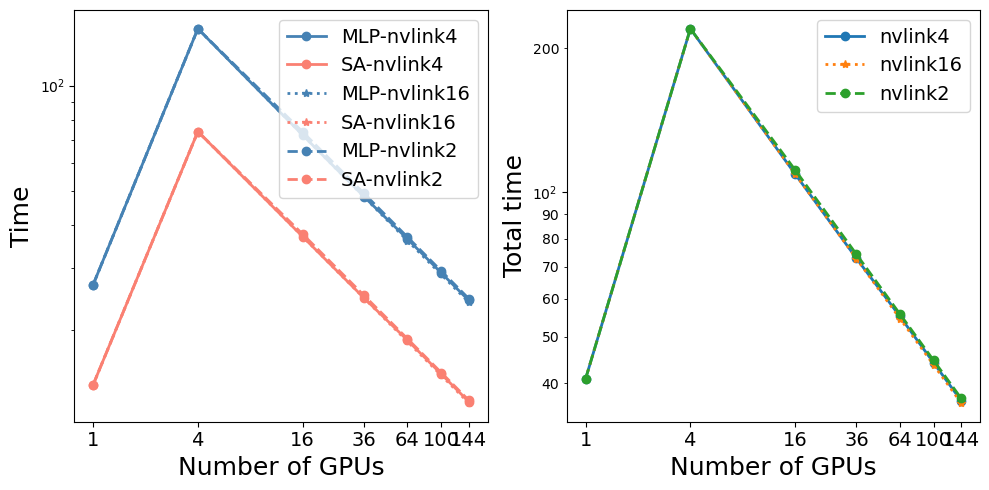

In [10]:
# Sweeps
### model parallelism
n_gpus = [1, 4, 16, 36, 64, 100, 144]
with open('systems/config-A100.json', 'r') as file:
    system = json.load(file)
fig, axs = plt.subplots(1,2,figsize=(10,5), tight_layout=True) 
c1 = 'steelblue'
c2 = 'salmon'
fsz = 18
system['summa_nb'] = 4
lgnd = []
lgnd_tot = []
nvs = 4
system['nvlink_size'] = nvs
lgnd = ["MLP-nvlink{}".format(nvs), "SA-nvlink{}".format(nvs)]
lgnd_tot = ["nvlink{}".format(nvs)]
plot_2d(n_gpus, system, axs, lgnd=lgnd, lgnd_tot=lgnd_tot, lfmt="o-")
nvs = 16
system['nvlink_size'] = nvs
lgnd += ["MLP-nvlink{}".format(nvs), "SA-nvlink{}".format(nvs)]
lgnd_tot += ["nvlink{}".format(nvs)]
plot_2d(n_gpus, system, axs, lgnd=lgnd, lgnd_tot=lgnd_tot, lfmt="*:")
nvs = 2
system['nvlink_size'] = nvs
lgnd += ["MLP-nvlink{}".format(nvs), "SA-nvlink{}".format(nvs)]
lgnd_tot += ["nvlink{}".format(nvs)]
plot_2d(n_gpus, system, axs, lgnd=lgnd, lgnd_tot=lgnd_tot, lfmt="o--")